In [3]:
import pandas as pd
import pysubgroup as ps
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_path = '../dataset/data.csv'

df = pd.read_csv(data_path)
print("Shape inicial:", df.shape)

Shape inicial: (8950, 18)


In [5]:
# Como tempos poucos dados, em vez de excluir os valores nulos, vamos substituí-los pela mediana da coluna
df = df.fillna(df.median(numeric_only=True))

## Primeiro Experimento: Identificação de clientes mais endividados

In [6]:
target = ps.NumericTarget('BALANCE')

search_space = ps.create_selectors(df, ignore=['CUST_ID', 'BALANCE'])

# Usaremos a StandardQF, que mede a diferença da média do subgrupo em desvios padrão
# O parâmetro 'a' ajuda a ponderar o tamanho do subgrupo.
quality_function = ps.StandardQFNumeric(a=0.5)

In [7]:
# Criando a tarefa de descoberta de subgrupos
task = ps.SubgroupDiscoveryTask(
    df,
    target,
    search_space,
    result_set_size=10,  # Queremos os 10 melhores subgrupos
    depth=3,             # Profundidade máxima da descrição
    qf=quality_function
)

# Executando a busca
result = ps.BeamSearch().execute(task)

In [8]:
media_global = df['BALANCE'].mean()
df_results = result.to_dataframe()

print("="*60)
print("Análise Detalhada dos Subgrupos de Maior Impacto")
print("="*60)
print(f"Média Global: R$ {media_global:,.2f}")

for index, row in df_results.iterrows():
    # Coletando os valores da linha
    qualidade = row['quality']
    descricao = row['subgroup']
    tamanho_subgrupo = row['size_sg']
    media_sg = row['mean_sg']

    # Imprimindo o "card" de resultado para cada subgrupo
    print(f"Qualidade: {qualidade:.3f} | Subgrupo: {descricao}")
    print(f"   > Tamanho: {tamanho_subgrupo:,.0f} cartões")
    print(f"   > Média do Subgrupo: R$ {media_sg:,.2f}")
    print("-" * 40)

Análise Detalhada dos Subgrupos de Maior Impacto
Média Global: R$ 1,564.47
Qualidade: 139102.674 | Subgrupo: CREDIT_LIMIT>=7000.0 AND MINIMUM_PAYMENTS>=994.39
   > Tamanho: 803 cartões
   > Média do Subgrupo: R$ 6,473.30
----------------------------------------
Qualidade: 138515.067 | Subgrupo: BALANCE_FREQUENCY>=1.0 AND CREDIT_LIMIT>=7000.0 AND MINIMUM_PAYMENTS>=994.39
   > Tamanho: 740 cartões
   > Média do Subgrupo: R$ 6,656.39
----------------------------------------
Qualidade: 135067.097 | Subgrupo: CREDIT_LIMIT>=7000.0 AND MINIMUM_PAYMENTS>=994.39 AND PRC_FULL_PAYMENT: [0.0:0.08[
   > Tamanho: 708 cartões
   > Média do Subgrupo: R$ 6,640.61
----------------------------------------
Qualidade: 133420.287 | Subgrupo: CREDIT_LIMIT>=7000.0 AND MINIMUM_PAYMENTS>=994.39 AND TENURE>=12
   > Tamanho: 726 cartões
   > Média do Subgrupo: R$ 6,516.17
----------------------------------------
Qualidade: 122549.928 | Subgrupo: MINIMUM_PAYMENTS>=994.39
   > Tamanho: 1,790 cartões
   > Média do S

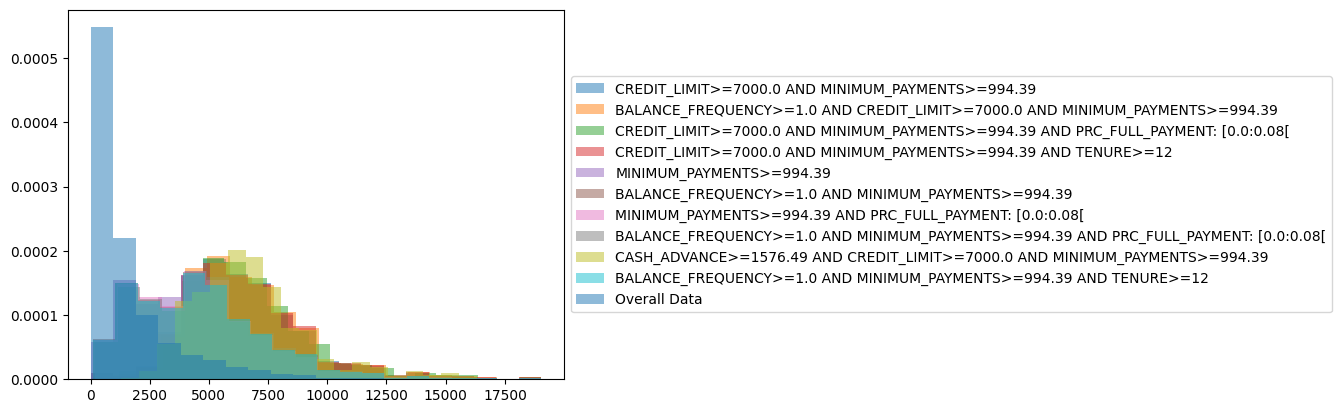

In [9]:
ps.plot_distribution_numeric(result.to_descriptions(), target, df, bins=20)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Interpretação do primeiro experimento

ATENÇÃO: ANÁLISE FEITA PELO GEMINI

O atributo "BALANCE" significa saldo devedor. Ou seja, ele é o valor total que ainda precisa ser pago na fatura. As características que mais se repetem e definem os grupos com saldo devedor mais alto são:

- **Pagamento Mínimo Elevado:** A condição MINIMUM_PAYMENTS >= 994.39 aparece em quase todas as regras de alta qualidade. Isso é um indicador direto de que o saldo devedor (BALANCE) total é muito alto, já que o pagamento mínimo é um percentual desse saldo. Este é o principal descritor encontrado, mas não descreve padrões muito interessantes, já que as duas variáveis sao correlacionadas.

- **Limite de Crédito Alto:** A segunda condição mais forte é CREDIT_LIMIT >= 7000.0. Clientes com alto limite de crédito tendem a acumular um saldo devedor maior.

- **Não Pagamento do Valor Total:** A regra PRC_FULL_PAYMENT: [0.0:0.08[ (ou seja, o cliente paga entre 0% e 8% do valor total da fatura) é um fator chave. Isso caracteriza o "cliente rotativo", que financia o saldo de um mês para o outro, acumulando juros e, consequentemente, aumentando o BALANCE.

- **Frequência de Atualização do Saldo:** A condição BALANCE_FREQUENCY >= 1.0 indica que o saldo desses clientes é atualizado com muita frequência, sugerindo que são usuários ativos do cartão.

**Insights principais**:
1. **O Saldo Mais Elevado:** O subgrupo com a maior média de saldo devedor (R$ 6.715,71) é aquele que combina limite alto, pagamento mínimo alto e, crucialmente, saques em dinheiro (Cash Advance) elevados (CASH_ADVANCE >= 1.576,49). Isso sugere que o comportamento de saque é um forte acelerador do saldo devedor para clientes que já possuem um perfil de alto endividamento.

2. **Clientes Antigos e Ativos:** Clientes mais antigos (TENURE >= 12) e com saldo frequentemente atualizado (BALANCE_FREQUENCY >= 1.0)  também são predominantes nesses grupos de alto saldo, indicando que esse comportamento de endividamento se consolida com o tempo de uso do cartão.

Em resumo, essa análise identificou com sucesso o perfil do cliente "endividado de alto valor": um cliente antigo, com alto limite, que não quita a fatura e usa o crédito rotativo, muitas vezes potencializado pelo uso de saques (cash advance).

## Segundo Experimento: Adição de Novas Variáveis

In [10]:
df['CREDIT_UTILIZATION'] = df['BALANCE'] / df['CREDIT_LIMIT']
df['CASH_RATIO'] = df['CASH_ADVANCE'] / df['PURCHASES']
df = df.replace([np.inf, -np.inf], 0)

In [11]:
target = ps.NumericTarget('BALANCE')

search_space = ps.create_selectors(df, ignore=['CUST_ID', 'BALANCE', 'MINIMUM_PAYMENTS'])

# Usaremos a StandardQF, que mede a diferença da média do subgrupo em desvios padrão
# O parâmetro 'a' ajuda a ponderar o tamanho do subgrupo.
quality_function = ps.StandardQFNumeric(a=0.5)

# Criando a tarefa de descoberta de subgrupos
task = ps.SubgroupDiscoveryTask(
    df,
    target,
    search_space,
    result_set_size=10,  # Queremos os 10 melhores subgrupos
    depth=5,             # Profundidade máxima da descrição
    qf=quality_function
)

# Executando a busca
result = ps.BeamSearch().execute(task)

In [12]:
media_global = df['BALANCE'].mean()
df_results = result.to_dataframe()

print("="*60)
print("Análise Detalhada dos Subgrupos de Maior Impacto")
print("="*60)
print(f"Média Global: R$ {media_global:,.2f}")

for index, row in df_results.iterrows():
    # Coletando os valores da linha
    qualidade = row['quality']
    descricao = row['subgroup']
    tamanho_subgrupo = row['size_sg']
    media_sg = row['mean_sg']

    # Imprimindo o "card" de resultado para cada subgrupo
    print(f"Qualidade: {qualidade:.3f} | Subgrupo: {descricao}")
    print(f"   > Tamanho: {tamanho_subgrupo:,.0f} cartões")
    print(f"   > Média do Subgrupo: R$ {media_sg:,.2f}")
    print("-" * 40)

Análise Detalhada dos Subgrupos de Maior Impacto
Média Global: R$ 1,564.47
Qualidade: 110765.510 | Subgrupo: BALANCE_FREQUENCY>=1.0 AND CREDIT_LIMIT>=7000.0 AND PRC_FULL_PAYMENT: [0.0:0.08[
   > Tamanho: 1,119 cartões
   > Média do Subgrupo: R$ 4,875.71
----------------------------------------
Qualidade: 110724.730 | Subgrupo: BALANCE_FREQUENCY>=1.0 AND CASH_ADVANCE>=1576.49 AND CREDIT_LIMIT>=7000.0
   > Tamanho: 625 cartões
   > Média do Subgrupo: R$ 5,993.46
----------------------------------------
Qualidade: 108987.352 | Subgrupo: BALANCE_FREQUENCY>=1.0 AND CASH_ADVANCE>=1576.49 AND CREDIT_LIMIT>=7000.0 AND PRC_FULL_PAYMENT: [0.0:0.08[
   > Tamanho: 525 cartões
   > Média do Subgrupo: R$ 6,321.07
----------------------------------------
Qualidade: 108069.883 | Subgrupo: CREDIT_LIMIT>=7000.0 AND CREDIT_UTILIZATION: [0.44:0.80[
   > Tamanho: 510 cartões
   > Média do Subgrupo: R$ 6,349.89
----------------------------------------
Qualidade: 107378.274 | Subgrupo: CASH_ADVANCE>=1576.49 

### Interpretação do Segundo Experimento

ATENÇÃO: ANÁLISE FEITA PELO GEMINI

Para este segundo experimento, criamos uma nova variável *CREDIT_UTILIZATION*, que permite entender o quão perto do limite o cliente está. Também, excluímos a variável *MINIMUM_PAYMENTS* dos descritores, pois a alta correlação dela com a variável alvo está retornando resultados redudantes. Por fim, aumentamos a profundidade (quantidade máxima de descritores) para 5, devido à alta quantidade de colunas no dataset que acaba gerando muitos descritores. Isso permitiu encontrarmos perfis mais específicos de clientes endividados.

**Análise Geral dos Resultados**

Mesmo sem a variável *MINIMUM_PAYMENTS*, os pilares que definem o cliente com alto saldo devedor (*BALANCE*) permanecem os mesmos, o que fortalece muito a sua conclusão inicial. As características dominantes continuam sendo:
- **Limite de crédito alto:** *CREDIT_LIMIT* >= 7000.0 está presente em praticamente todas as regras de alta qualidade.

- **Pagamento Parcial da Fatura:** *PRC_FULL_PAYMENT*: [0.0:0.08[ (não pagar a fatura integralmente) continua sendo um fator crucial para identificar o cliente "rotativo".
- **Uso Elevado de Saque:** *CASH_ADVANCE* >= 1576.49 se consolida como um comportamento chave, associado aos saldos médios mais altos.

**O Impacto da Nova Variável:** *CREDIT_UTILIZATION*

A grande novidade aqui é a *CREDIT_UTILIZATION* (Utilização do Crédito), que representa a proporção do limite que o cliente está efetivamente usando (*BALANCE* / *CREDIT_LIMIT*). Esta variável trouxe um dos insights mais poderosos da nova análise.
- **Subgrupo de Alta Utilização**: Foi encontrado um subgrupo definido por *CREDIT_LIMIT* >= 7000.0 e *CREDIT_UTILIZATION*: [0.44:0.80[. Este subgrupo não inclui apenas clientes com limite alto, mas especificamente aqueles que estão usando entre 44% e 80% desse limite alto. Eles estão se aproximando da sua capacidade máxima de endividamento.

- **Utilização e Atividade**: Quando essa condição é combinada com *BALANCE_FREQUENCY* >= 1.0 (cliente ativo), a média de saldo sobe mais ainda. Isso descreve um perfil de alto risco: um cliente ativo que está consistentemente operando com seu limite de crédito quase no máximo.

**O Perfil "Tempestade Perfeita":** O Poder da Profundidade

Ao aumentar a profundidade para 5, conseguimos identificar um "superperfil" que combina múltiplos fatores de risco. O último subgrupo da lista é o mais específico e revelador:
- **Subgrupo:** *BALANCE_FREQUENCY* >= 1.0 E *CASH_ADVANCE* >= 1576.49 E *CREDIT_LIMIT* >= 7000.0 E *PRC_FULL_PAYMENT*: [0.0:0.08[ E *TENURE* >= 12.

- **Tamanho:** 483 cartões.
- **Média do Subgrupo:** R$ 6.380,45.

Este é o retrato do cliente com o maior potencial de endividamento e risco. Ele é um cliente antigo e ativo que possui limite alto, não paga a fatura integralmente e ainda utiliza o saque (cash advance) de forma intensiva. A combinação simultânea desses cinco fatores descreve um micro-segmento extremamente valioso para ações de negócio focadas, seja para oferta de produtos de renegociação de dívida ou para um monitoramento de risco mais próximo.

**Conclusões e Insights Acionáveis**
1. **Validação do Perfil "Rotativo":** A análise validou que o perfil do cliente com alto saldo devedor é o "rotativo", mesmo sem a variável mais óbvia (*MINIMUM_PAYMENTS*).

2. **CREDIT_UTILIZATION é Chave:** A utilização do crédito se mostrou um indicador de risco muito mais inteligente e preciso do que apenas o limite. Segmentar clientes com alta utilização (acima de 44%) é uma estratégia clara para a gestão de risco.
3. **Identificação de Micro-Segmentos de Alto Risco:** O aumento da profundidade permitiu encontrar o perfil "tempestade perfeita". Embora seja um grupo menor (483 clientes), ele concentra os comportamentos mais arriscados e pode ser o alvo principal para ações proativas, como a oferta de empréstimos para consolidação da dívida com juros mais baixos que os do rotativo e do saque.

## Terceiro Experimento: Criação de Novos Perfis de Clientes

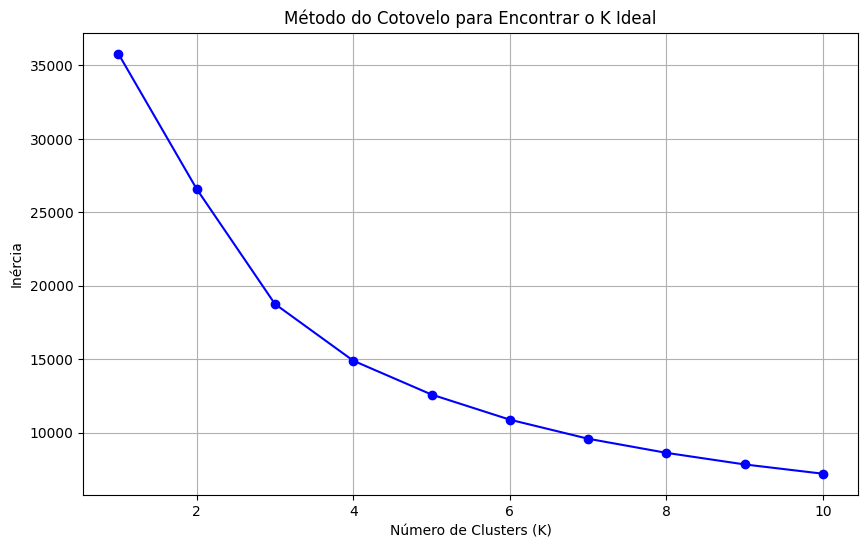


--- Perfil dos Clusters (Médias) ---
            PURCHASES      BALANCE  PRC_FULL_PAYMENT  CASH_ADVANCE
CLUSTER                                                           
0          690.509951  1105.050571          0.039281    505.883452
1          909.281908  5365.411473          0.024534   4520.616673
2         1385.684719   145.665771          0.775691    116.755413
3        13597.846992  4391.214449          0.299019    777.132520

--- Tamanho de Cada Cluster ---
CLUSTER
0    6277
2    1371
1    1179
3     123
Name: count, dtype: int64


In [13]:
features = df[['PURCHASES', 'BALANCE', 'PRC_FULL_PAYMENT', 'CASH_ADVANCE']]

# Padronização dos dados (passo crucial para K-Means)
# Isso garante que todas as variáveis tenham a mesma escala e importância
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Vamos testar de 1 a 10 clusters
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Encontrar o K Ideal')
plt.grid(True)
plt.show()

ideal_k = 4

# Criar e treinar o modelo K-Means final
kmeans = KMeans(n_clusters=ideal_k, n_init=10, random_state=42)
kmeans.fit(scaled_features)

# Adicionar a nova variável alvo (os clusters) ao DataFrame original
df['CLUSTER'] = kmeans.labels_

# --- Interpretação dos Segmentos Criados ---

# Calcular as médias das características originais para cada cluster
# Isso nos ajuda a entender a "personalidade" de cada grupo
cluster_profiles = df.groupby('CLUSTER')[['PURCHASES', 'BALANCE', 'PRC_FULL_PAYMENT', 'CASH_ADVANCE']].mean()

print("\n--- Perfil dos Clusters (Médias) ---")
print(cluster_profiles)
print("\n--- Tamanho de Cada Cluster ---")
print(df['CLUSTER'].value_counts())

# Cluster 0: Gasto baixo, saldo alto, não paga em dia. (Rotativos/Endividados)
# Cluster 1: Gasto baixo, saldo alto, uso intenso de saque. (Emergenciais/Devedores de Saque)
# Cluster 2: Gasto alto, saldo baixo, paga tudo em dia. (Transatores/Bons Pagadores)
# Cluster 3: Gasto alto, saldo alto, pagam grande parte. (Compradores VIP)

In [14]:
# Vamos rodar uma descoberta para cada perfil
for i in range(4):
    df['perfil_alvo'] = (df['CLUSTER'] == i)
    target = ps.BinaryTarget('perfil_alvo', True)

    # Excluindo as variáveis que foram usadas na clusterização
    search_space = ps.create_selectors(df, ignore=['CUST_ID', 'BALANCE', 'MINIMUM_PAYMENTS', 'PURCHASES',
                                                'PRC_FULL_PAYMENT', 'CASH_ADVANCE', 'perfil_alvo', 'CLUSTER',
                                                'CASH_RATIO'])

    quality_function = ps.WRAccQF()

    # Criando a tarefa de descoberta de subgrupos
    task = ps.SubgroupDiscoveryTask(
        df,
        target,
        search_space,
        result_set_size=10,  # Queremos os 10 melhores subgrupos
        depth=5,             # Profundidade máxima da descrição
        qf=quality_function
    )

    # Executando a busca
    result = ps.BeamSearch().execute(task)
    df_results = result.to_dataframe()

    cobertura_global = df['perfil_alvo'].mean()
    print("=" * 60)
    print(f"IMPRESSÃO DOS RESULTADOS DO PERFIL {i}")
    print(f"Concentração Global de Clientes do perfil {i}: {cobertura_global:.2%}")
    print("=" * 60)
    print()

    for index, row in df_results.iterrows():
        cobertura_subgrupo = row['positives_sg'] / row['size_sg']
        print(f"Qualidade (WRAcc): {row['quality']:.4f} | Subgrupo: {row['subgroup']}")
        print(f"   > Concentração de Clientes do perfil {i}: {cobertura_subgrupo:.2%} ({row['positives_sg']:,.0f} de {row['size_sg']:,.0f} cartões)")
        print("-" * 40)

IMPRESSÃO DOS RESULTADOS DO PERFIL 0
Concentração Global de Clientes do perfil 0: 70.13%

Qualidade (WRAcc): 0.0345 | Subgrupo: PAYMENTS<313.23
   > Concentração de Clientes do perfil 0: 87.37% (1,564 de 1,790 cartões)
----------------------------------------
Qualidade (WRAcc): 0.0312 | Subgrupo: CREDIT_LIMIT: [1500.0:2500.0[
   > Concentração de Clientes do perfil 0: 87.83% (1,386 de 1,578 cartões)
----------------------------------------
Qualidade (WRAcc): 0.0310 | Subgrupo: PURCHASES_TRX: [0:4[
   > Concentração de Clientes do perfil 0: 78.29% (2,665 de 3,404 cartões)
----------------------------------------
Qualidade (WRAcc): 0.0305 | Subgrupo: PURCHASES_FREQUENCY: [0.0:0.25[
   > Concentração de Clientes do perfil 0: 78.40% (2,591 de 3,305 cartões)
----------------------------------------
Qualidade (WRAcc): 0.0296 | Subgrupo: PURCHASES_FREQUENCY: [0.0:0.25[ AND PURCHASES_TRX: [0:4[
   > Concentração de Clientes do perfil 0: 78.44% (2,500 de 3,187 cartões)
-------------------------

### Interpretação dos resultados

ATENÇÃO: ANÁLISE FEITA PELO GEMINI

Neste último experimento, empregamos uma técnica de clusterização (K-Means) para identificar tipos específicos de clientes, baseado no comportamento de algumas variáveis (PURCHASE, BALANCE, PRC_FULL_PAYMENT, CASH_ADVANCE).

Com isso, chegamos a 4 tipos diferentes de classes de pessoas que utilizam os cartões:
- Rotativos (endividados)
- Emergenciais (devedores de saque)
- Transatores (bons pagadores)
- Clientes VIP (compras altas)

Depois, rodamos a descoberta de subgrupos analisando individualmente cada perfil como a variável alvo, a fim de entendermos quais são as características específicas de cada um destes perfis. Os resultados estão apresentados abaixo.

**Perfil 1: O "Rotativo Padrão" de Baixa Atividade**

**Persona:** Este é o maior grupo de clientes (70,13% do total), que possui um saldo devedor moderado e não paga a fatura em dia.

**O que os resultados nos dizem:** As regras encontradas pintam um retrato claro de um cliente de **baixa atividade e baixo engajamento**:
- **Pagamentos Baixos:** A regra mais forte (*PAYMENTS* < 313.23) mostra que eles fazem pagamentos absolutos muito baixos.

- **Limite de Crédito Restrito:** Eles tendem a ter um limite de crédito em uma faixa específica e mais baixa, entre R$ 1.500 e R$ 2.500.
- **Pouquíssimas Compras:** As regras mais recorrentes apontam para um número muito baixo de transações de compra (*PURCHASES_TRX*: [0:4[) e uma frequência de compra quase nula (*PURCHASES_FREQUENCY*: [0.0:0.25[).

**Conclusão sobre o Perfil 1:** Este não é apenas um "rotativo padrão", mas um **"rotativo passivo"**. É um cliente com pouco envolvimento com o cartão, que talvez tenha feito algumas compras no passado, não quitou o saldo e agora apenas administra essa dívida sem gerar novas transações significativas.

**Perfil 2: O "Super Endividado de Saque"**

**Persona:** Um grupo de alto risco com saldo devedor altíssimo, impulsionado pelo uso extremo de saques (cash advance). Representam 13,17% da base.

**O que os resultados nos dizem:** As regras confirmam e detalham o comportamento de dependência do saque:
- **Comportamento de Saque é o Fator Chave:** As regras mais fortes e que mais se repetem são ligadas diretamente à frequência (*CASH_ADVANCE_FREQUENCY* >= 0.25) e ao volume de transações de saque (*CASH_ADVANCE_TRX* >= 5). Um cliente que faz 5 ou mais saques tem 43,16% de chance de pertencer a este grupo, um salto enorme em relação à média global de 13,17%.

- **São Clientes Antigos e Ativos:** As regras também mostram que eles são clientes de longa data (*TENURE* >= 12) e com o saldo frequentemente atualizado (*BALANCE_FREQUENCY* >= 1.0), indicando que não é um problema de "primeiro uso", mas um comportamento consolidado.
- **Possuem Limite Alto:** O algoritmo confirma que ter um limite de crédito alto (*CREDIT_LIMIT* >= 7000.0) também é uma característica deste grupo.

**Conclusão sobre o Perfil 2:** Este perfil é claramente definido por um **hábito de usar o saque como fonte de liquidez**. As regras são tão específicas que podem ser usadas para criar alertas em tempo real para o departamento de risco.

**Perfil 3: Os "Transatores" Disciplinados**

**Persona:** Os "bons pagadores", que usam o cartão para compras mas mantêm o saldo devedor baixíssimo. Compõem 15,32% da base.

**O que os resultados nos dizem:** As regras descrevem este grupo principalmente pelo que eles **NÃO FAZEM:**
- **Não Usam Saque:** A regra mais forte e repetida é a ausência quase total de saques (*CASH_ADVANCE_TRX*: [0:1[ e *CASH_ADVANCE_FREQUENCY*: [0.0:0.08[). Um cliente que não faz saques tem 26,62% de chance de ser um "Transator", quase o dobro da média global.

- **Utilização de Crédito Mínima:** A segunda regra mais poderosa é a baixíssima utilização do crédito (*CREDIT_UTILIZATION* < 0.02). Eles usam menos de 2% do limite disponível, mostrando enorme disciplina financeira.
- **São Clientes Leais:** Assim como o grupo de risco, eles também tendem a ser clientes antigos (*TENURE* >= 12).

**Conclusão sobre o Perfil 3:** Este cliente é definido pela **disciplina financeira e aversão à dívida**. Eles são leais e usam o cartão de forma inteligente. São um pilar de estabilidade para o negócio.

**Perfil 4: Os "Grandes Compradores VIP"**

**Persona:** Um grupo pequeno (apenas 1,37% da base) e de elite, com um volume de compras extraordinário.

**O que os resultados nos dizem:** As regras descrevem com precisão os hábitos de consumo deste grupo de elite:
- **Compras Únicas de Alto Valor:** A característica mais forte é o valor de suas compras únicas (*ONEOFF_PURCHASES* >= 817.32).

- **Pagamentos Elevados:** Eles realizam pagamentos de alto valor (*PAYMENTS* >= 2314.21), o que é consistente com seus gastos elevados.
- **Alta Frequência e Volume de Transações:** Eles são muito ativos, com um alto número de transações (*PURCHASES_TRX* >= 22) e alta frequência de compras à vista (*ONEOFF_PURCHASES_FREQUENCY* >= 0.42).
- **Lealdade:** Mais uma vez, são clientes de longa data (*TENURE* >= 12).

**Conclusão sobre o Perfil 4:** Este é um cliente **VIP engajado, leal e de alto poder aquisitivo**, que utiliza o cartão como principal ferramenta para compras de alto valor. As regras encontradas podem ser usadas para identificar potenciais clientes para um programa de recompensas "premium".